# langsung dari library efficientnet

In [1]:
import warnings
warnings.filterwarnings("ignore") # fp16 scaling really bugging the shit out of jupyter lab, results in RAM memory leak. :(

In [2]:
# list all train images + labels according to folders -> df
import pandas as pd
from fastai.vision import *

def get_data(bs, size): 
    tfms = get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()])
    return ImageDataBunch.from_folder(Path('./dataset'),
                                  train = 'train/',
                                  valid_pct = 0.1,
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms = tfms,
                                  size = size,
                                  bs = bs,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

data = get_data(64, 299)
img_path = [str(x) for x in list(data.train_ds.items)] + list(data.valid_ds.items)
labels = [data.classes[x] for x in list(data.train_ds.y.items) + list(data.valid_ds.y.items)]
# del data

In [4]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()

In [5]:
learn.load('baseline')

Learner(data=ImageDataBunch;

Train: LabelList (105826 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
test,test,test,test,test
Path: dataset;

Valid: LabelList (11758 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
17,21,04,21,41
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d

In [6]:
# Second last layer of the model
learn.model[1][4]

Linear(in_features=4096, out_features=512, bias=True)

In [7]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [8]:
sf = SaveFeatures(learn.model[1][4])

In [10]:
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [11]:
len(sf.features)

117584

In [12]:
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]

In [13]:
len(img_path), len(label), len(label_id)

(117584, 117584, 117584)

In [14]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
df_new

,img_path,label,label_id
0,dataset/test/0004b03ad7eabfb3989727c461310a84.jpg,test,42
1,dataset/test/0012f125ad07123e69468ae1d1d59de4.jpg,test,42
2,dataset/test/0015831b249b856e569e883a9dc6d4fa.jpg,test,42
3,dataset/test/00196f6ef552b2c4d78365818acdbce2.jpg,test,42
4,dataset/test/001d40e7718c79ed31750d6c988a90fc.jpg,test,42
...,...,...,...
117579,dataset/test/82b06cde75f820bd89165b7276f60109.jpg,test,42
117580,dataset/train/28/983f446c8fa0e037abc2b5c9459da...,28,28
117581,dataset/train/02/c2acb3fefb5b7e43f227a0811eac1...,02,2
117582,dataset/train/30/4f24153104040f73e161641d69ca6...,30,30


In [15]:
feature_vectors = np.array(sf.features)
x = feature_vectors.tolist()

In [16]:
df_new[
    'vectors'
] = x

In [17]:
df_new.head()

,img_path,label,label_id,vectors
0,dataset/test/0004b03ad7eabfb3989727c461310a84.jpg,test,42,"[-15.203125, -34.75, 13.515625, -89.375, 11.99..."
1,dataset/test/0012f125ad07123e69468ae1d1d59de4.jpg,test,42,"[-1.521484375, 1.3935546875, 1.4921875, -11.65..."
2,dataset/test/0015831b249b856e569e883a9dc6d4fa.jpg,test,42,"[28.375, 28.953125, -57.46875, -39.875, 6.7539..."
3,dataset/test/00196f6ef552b2c4d78365818acdbce2.jpg,test,42,"[-79.375, 14.3515625, 15.4375, -26.25, 9.38281..."
4,dataset/test/001d40e7718c79ed31750d6c988a90fc.jpg,test,42,"[-17.265625, -39.59375, -0.7841796875, -23.468..."


In [18]:
df_new.to_pickle('image_Resnet50_vectors.pkl')

In [19]:
!pip install pyarrow annoy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
from annoy import AnnoyIndex

f = len(df_new['vectors'][0])
tt = AnnoyIndex(f, metric='euclidean')

In [21]:
f

512

In [22]:
n_tree = 100

for i, v in enumerate(df_new['vectors']): 
    tt.add_item(i, v)
_ = tt.build(n_tree)

In [23]:
import time
def get_similar_image_by_index(img_index, df=df_new, t = tt): 
    start = time.time()
    base_img_id, base_vec, base_label = df.iloc[img_index, [0,3,1]]
    similar_img_ids = t.get_nns_by_item(img_index, 8)
    
    end = time.time() - start
    print(end, 's')
    return base_img_id, base_label, df.iloc[similar_img_ids]

In [24]:
base_img, base_label, similar_images_df = get_similar_image_by_index(123)

0.0018641948699951172 s


In [25]:
df_new.columns

Index(['img_path', 'label', 'label_id', 'vectors'], dtype='object')

In [26]:
base_label

'test'

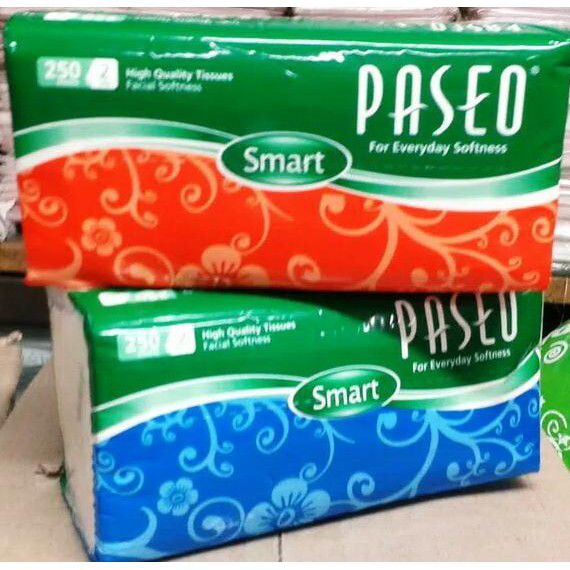

In [27]:
open_image(base_img)

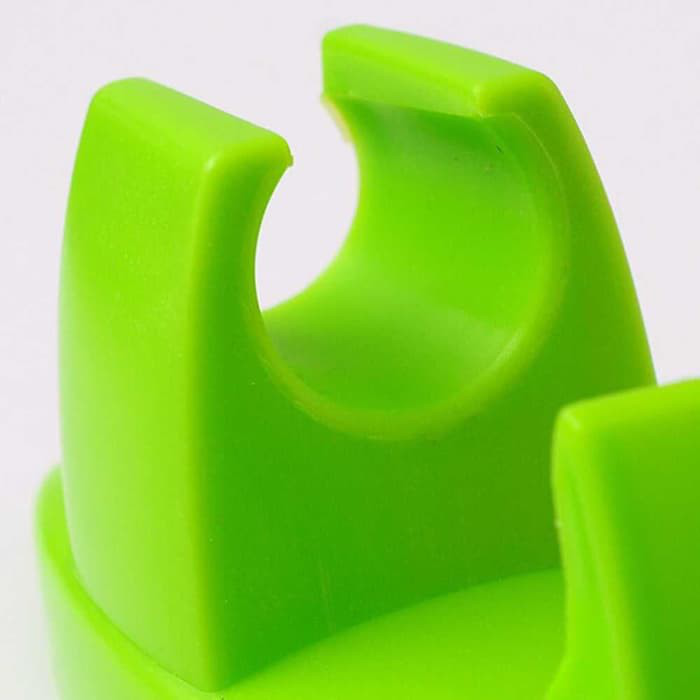

In [28]:
open_image(df_new.loc[101564].img_path)

In [29]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

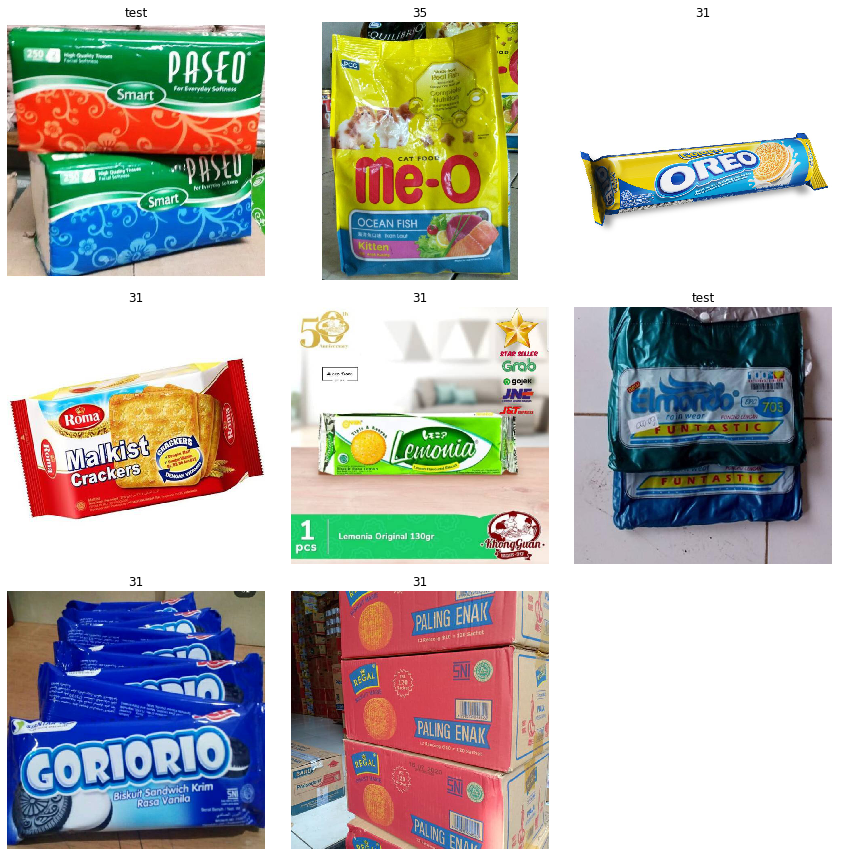

In [30]:
show_similar_images(similar_images_df)

In [ ]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in df_new['vectors'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100, n_jobs=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 117584 samples in 17.198s...


In [ ]:
!pip install sklearn

In [ ]:
df_new['tsne1'] = tsne_results_3[:,0]
df_new['tsne2'] = tsne_results_3[:,1]
df_new['tsne3'] = tsne_results_3[:,2]

In [ ]:
df_new.to_pickle('shopee_baseline_with_tsne.pkl')

In [ ]:
import plotly_express as px
px.scatter_3d(df_new, x='tsne1', y='tsne2', z='tsne3', color='label')